In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

# Day 1: Overview of TF2


- Libraries and frameworks for Deep Learning
- Build a model with tf.keras (the easy way)
- Customise models, metrics and training loops
- Visualise statistics with TensorBoard
- DL programming paradigms: Symbolic vs. Imperative Programs
- Backpropagation and AutoDiff

### Libraries and frameworks for Deep Learning

**< 2010**
    - Torch
    - Theano
    
**2013**
    - Caffe

**2015**
    - MXNet
    - Chainer
    - TensorFlow
    - PaddlePaddle
    
**2016**
    - Microsoft Cognitive Toolkit (CNTK)
    - PyTorch
    
**2017**
    - Caffe 2

###  Stars / Contributors on GitHub
![stars/contributors](https://www.kdnuggets.com/wp-content/uploads/top-16-deep-learning-libs-691.jpg)

### 2018 
![jod_ads](https://miro.medium.com/max/1400/1*kA8dIgRqLdWgKgs2sd7clA.png)

### Late 2019
![pytorch_vs_tf](https://thegradient.pub/content/images/2019/10/ratio_medium-1.png)

## Why researchers are moving away from TF?

1. TF1.x had a high entry threshold for beginners
2. Debugging models can be frustrating 
3. Changed APIs too many times: ‘layers’ -> ‘slim’ -> ‘estimators’ -> ‘tf.keras’

## Why it is still used?

1. The above problems have been addressed and TF2 improves accessibility 
2. Great documentions and tutorials
3. It’s backed by a large community
4. Enables cross-platform deployment of models (TF.lite, TF.js, TFX)

## How to install

Tensorflow can be easily installed using `conda` or `pip`.

- `pip` (make sure `python3` is installed)
```
python3 -m venv ~/envs/tf2
source ~/envs/tf2/bin/activate
pip install tensorflow==2.2.0
pip install scikit-learn matplotlib jupyter pydot graphviz
```

- `conda` (usually the latest TensorFlow versions are not immediately available).
```
conda create -n tf2 python=3.7
conda activate tf2
conda install tensorflow=2.0
conda install sklearn matplotlib jupyter pydot graphviz
```

To test the installation open a python shell and import TensorFlow:

In [29]:
import tensorflow as tf
tf.__version__

'2.2.0'

## Build a model with tf.keras (the easy way)

Now that we have TensorFlow installed we can start playing with it!

## The easiest way: the Sequential API

The first Neural Network we build is a Multi Layer Perceptron to solve a classification problem. In the following slides we will see just the main steps, for the full code check the notebook [1.Sequential.ipynb](./1.Sequential.ipynb).
![MLP](https://corochann.com/wp-content/uploads/2017/02/mlp-800x367.png)

In this example we tackle the problem of classifying the images of the `fashion_mnist` dataset.
It consists of 70k images (60k for train and 10k for test) with $28\times28$ pixels and a single channel. The images come with a target label that splits the dataset in 10 balanced classes.

In [30]:
from sklearn.model_selection import train_test_split
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test                      = x_train.astype(np.float32)/255., x_test.astype(np.float32)/255.
x_train, x_val, y_train, y_val       = train_test_split(x_train, y_train, test_size=5000)

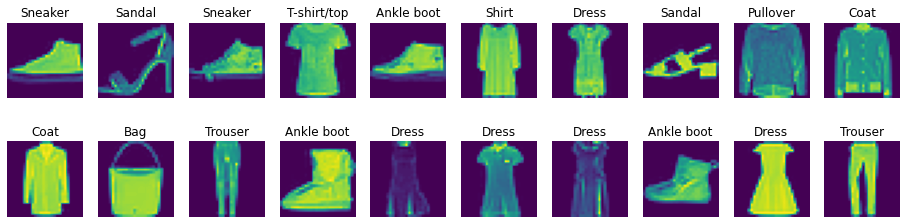

In [31]:
from utils import display_fashion_mnist
display_fashion_mnist(x_train[:20], y_train)

### Define a classifier
To create a classifier we use the `Sequential` API from the `tf.keras` module. To define a model this way is very easy: just put all the layers you want to add in a list and the API will create a model stacking them sequentially.

In [32]:
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Sequential
MLP = Sequential([
        Flatten(input_shape=[28, 28]),
        Dense(100, activation="relu"),
        Dense(50, activation="relu"),
        Dense(10, activation="softmax")
])

That's it! The `MLP` model stacks together a "flatten" layer, 2 hidden linear layers, and the output layer.
Note that:
- We specified the shape of input just for the first layer.
- The 2 hidden layers have ReLU activation function.
- As we are facing a classification problem the last layer has a softmax activation.

We can inspect the model by displaying the layers, their names, and their parameters using the `summary()` method..

In [33]:
MLP.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


..or in a fancy graph using the function `tf.keras.utils.plot_model`.

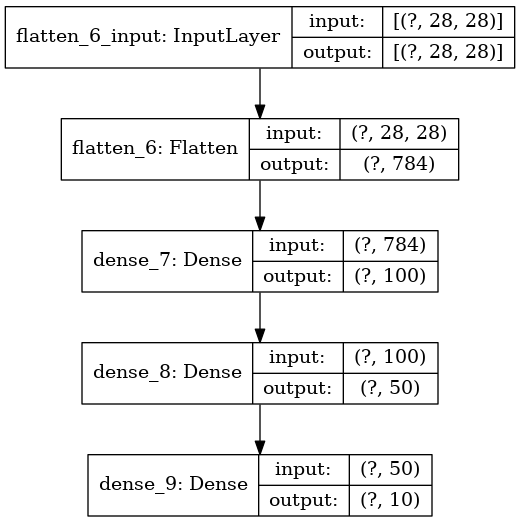

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(MLP, show_shapes=True)

### Compile it ...
Now we specify the loss function, the optimizer to use and, optionally, some metrics we want to track during training. 

In [35]:
MLP.compile(loss='sparse_categorical_crossentropy',
            optimizer='sgd')

### ... and train it! 

In [36]:
MLP.fit(x=x_train, y=y_train, epochs=3, batch_size=16, validation_data=(x_val, y_val))

Epoch 1/3
3438/3438 [==============================] - 4s 1ms/step - loss: 0.6549 - val_loss: 0.5133
Epoch 2/3
3438/3438 [==============================] - 4s 1ms/step - loss: 0.4594 - val_loss: 0.4819
Epoch 3/3
3438/3438 [==============================] - 4s 1ms/step - loss: 0.4148 - val_loss: 0.4470


Let's check the full code in the [notebook](./1.Sequential.ipynb)!

## A little more complexity: the Functional API

The `Sequential` API is surely powerfull but it isn't really flexible. What if we need to define a model whose topology is not linear? This can happen, for example, when using *skip connections* to link layers at different levels of the stack, when the network requires more than one input layer, or when it produces more than one output.

![complex_graph](https://keras.io/img/guides/functional_api/functional_api_40_0.png)

All the above cases and, more in general, all networks that can be represented by a Direct Acyclic Graph (DAG) can be implemented using the **Functional API**.

Let's build, as an example, a model with two inputs..

In [37]:
from tensorflow.keras.layers import Input, Dense, Concatenate

input_1 = Input(shape=[4], name='deep_in')
tower1  = Dense(10, activation="relu")(input_1)
tower1  = Dense(10, activation="relu")(tower1)

input_2 = Input(shape=[3], name='wide_in')
tower2  = Dense(20, activation="relu")(input_2)

concat  = Concatenate()([tower1, tower2])
output  = Dense(1, activation=None)(concat)

multi_in = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

The implementation is pretty simple: We start by creating the input nodes `wide_in` and `deep_in`. We create a new node calling a layer constructor (e.g. `Dense(20, activation="relu")`) and then, feeding to the new layer the desired input, we connect the nodes by an arrow.

Lastly, we define a Model specifying the layers that act as the input and output to the model.

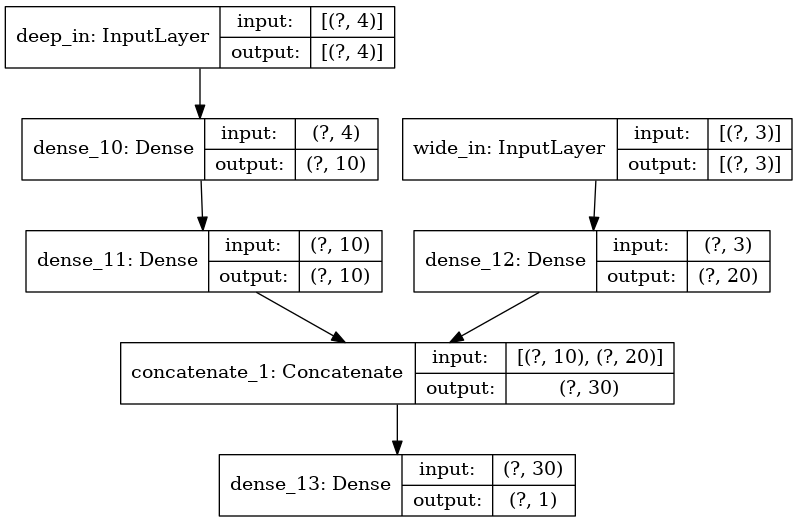

In [38]:
plot_model(multi_in, show_shapes=True)

This is a simplified version of the *wide and deep* model. It is one of the models used to solve a regression problem in the [second notebook](./2.Functional.ipynb).

Sometimes it is useful to have extra outputs. This could, for example, be because we want to exploit the network ability to learn meaningful representation of the data and perform multitasks classification. Another reason for having different outputs in deep networks is to make sure that the gradient does not vanish and flows in the network propagating to the lower layers. A famous example is GoogleNet:
![GoogleNet](https://miro.medium.com/max/4800/1*ZFPOSAted10TPd3hBQU8iQ.png)
If you want more details about the Inception module, check the notebook [A.Inception](A.Inception.ipynb).

The definition of a multi output model is as before.
Just declare all the outputs in list when creating the Model object:

In [39]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense

input_ = Input(shape=(28, 28, 1))
x = Conv2D(16, 3, strides=(2,2), padding='same', activation="relu")(input_)
x = Conv2D(32, 3, strides=(2,2),padding='same', activation="relu")(x)

aux_out = Flatten()(x)
aux_out = Dense(10, activation='softmax', name="aux_output")(aux_out)

x = Conv2D(64, 3, strides=(2,2), padding='same', activation="relu")(x)
x = Flatten()(x)
main_out = Dense(10, activation='softmax', name="main_output")(x)

multi_out = tf.keras.Model(inputs=input_, outputs=[main_out, aux_out])

As we will see now, it is useful when dealing with multiple inputs/outputs to assign them a name. 

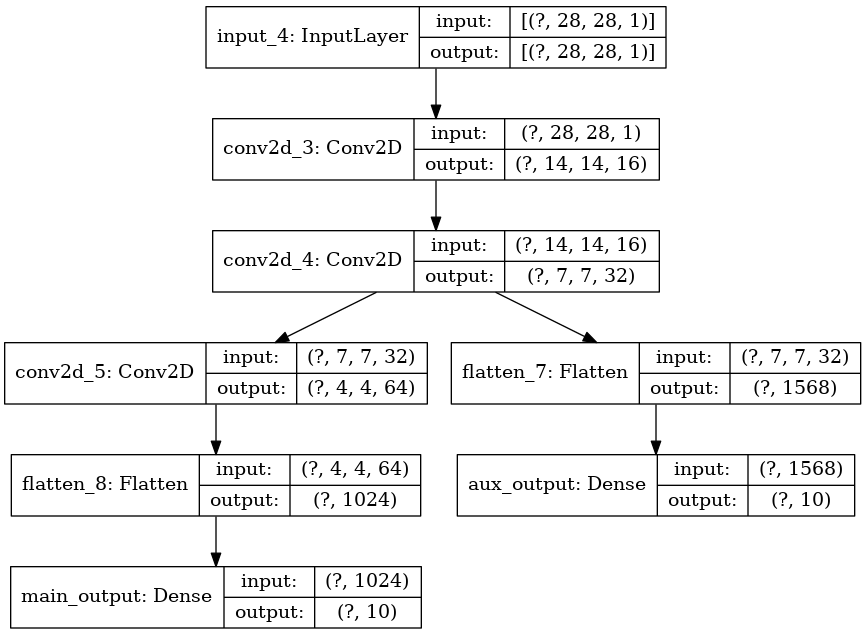

In [40]:
plot_model(multi_out, show_shapes=True)

When we compile, train or call the model we can feed the inputs and the targets following the same order used defining the model (this can lead to confusion!) or by passing a dictionary using their names as keys.

In [41]:
multi_out.compile(loss={"aux_output": 'sparse_categorical_crossentropy',
                        "main_output": 'sparse_categorical_crossentropy'},
                  loss_weights={"aux_output": 0.3, "main_output": 0.7},
                  optimizer="RMSProp",
                  metrics=["accuracy"])

In [42]:
multi_out.fit(x=x_train,
              y=(y_train, y_train),
              batch_size=16,
              epochs=1)

3438/3438 [==============================] - 7s 2ms/step - loss: 0.4689 - main_output_loss: 0.4651 - aux_output_loss: 0.4778 - main_output_accuracy: 0.8329 - aux_output_accuracy: 0.8308


## Control the training: the Callbacks
Callbacks are objects that can perform actions at given moments of the training:
at the start or at the end of an epoch, before or after each step, or even at a precise step! You can use callback for **monitoring the internal state of the network**, or to perform actions like saving the weights or **decaying the learning rate** when certain conditions are met. Another common use is **early stopping** to halt the training when the network reached a minimum of the generalisation error.

For example, to save the Keras model at specific intervals (by default the end of each epoch) there is the `ModelCheckpoint` callback. This is  crucial when you're training model on relatively large datasets to avoid loosing your progresses in case of failures.

To use it, initialise the callback object specifying the file where to store the model..

In [43]:
# Define the path of the file that stores the checkpoint
log_dir = os.path.join("logs","slides")
os.makedirs(log_dir, exist_ok=True)
ckpt_file = os.path.join(log_dir,"MLP_ckpt.h5")

# Initialise the callback by passing the path 
cb_model_ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_file)

.. then you pass it as argument of the `fit` method.

In [44]:
MLP.fit(x=x_train, y=y_train, epochs=2,
        validation_data=(x_val, y_val), 
        callbacks=[cb_model_ckpt])

Epoch 1/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3796 - val_loss: 0.3809
Epoch 2/2
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3668 - val_loss: 0.4024


In [45]:
! ls {log_dir}

20200615_133410  20200615_230050  20200616_094619  custom  MLP_ckpt.h5


The frequency it should save at and other *interesting* options can be specified, check the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)!

A usefull technique to avoid overfitting and wasting computational resources over training a model is **early stopping**. It consists of stopping the training before the last epoch when a condition is triggered. It can be esily implemented with `tf.keras` using the `EarlyStopping` callback:

In [46]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
                    # Stop training when `val_loss` is no longer improving
                    monitor='val_loss',
                    # "no longer improving" -> "for at least 2 epochs"
                    patience=3,
                    # restore the weights from the epoch with the best value monitored
                    restore_best_weights=True)

Another use for callbacks is the **learning rate scheduling**. Let's assume we want to decrease the learning rate at particular epochs:

In [47]:
def step_decay(epoch):
    if epoch < 10:
        return 1e-3
    elif epoch < 20:
        return 1e-4
    else:
        return 1e-5

cb_lr_sched = tf.keras.callbacks.LearningRateScheduler(step_decay)

As before, to use it just add it to the list of callbacks in the `fit` method. 

Similarly, if we want to save the event files to visualise the training statistics on **TensorBoard** we should use its specific callback:

In [48]:
from datetime import datetime
model_log_dir  = os.path.join(log_dir, datetime.now().strftime('%Y%m%d_%H%M%S'))
cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=model_log_dir)

The second line looks horrible but the only thing it does is to create the name of a new folder based on the current time. This is useful to avoid overwriting event files of subsquent training phases and messing up the statistics (don't worry, we will do it anyway just for fun).

The `TensorBoard` callback can offer much more than "just" live plot of metrics and losses. You can check histograms of the activations, get 3D projections of the representations learnt by the `Embedding` layers and even access a profile tool (still at early stages, it was introduced in the last version v 2.2.0).

We can combine all the above callbacks together and check the statistics on TensorBoard.
To do so run from your terminal:
```
tensorboard --logdir="logs/"
```

In [49]:
MLP.fit(x=x_train, y=y_train, epochs=100,
        validation_data=(x_val, y_val),
        verbose=0,
        callbacks=[cb_model_ckpt, cb_early_stop, cb_lr_sched, cb_tensorboard])

Check [the notebook](4.Callbacks.ipynb)

# Symbolic APIs
We have seen so far how to build a model using the Sequential and the Functiona APIs. These APIs are called **symbolic** (or **declarative**) because first we define the model by declaring its layers and their connections and just then we can evaluate it letting data flow through the computational graph. 

As we have seen, using this style we can create graphs of layers just as easy as to plug together Lego bricks to build a tower.

*Note:* TensorFlow 1 has been designed using the same paradigm. With much lower level APIs you define a model by declaring its computational graphs, and then you can execute it. It could feel much like interacting directly with a compiler, with all the pain of the case.

# Imperative APIs: Layer and Model subclassing
If static graphs are not enough and you need extra flexibility in your models or if you just prefer an imperative programming style you should use the **subclassing** API.

As Keras is based on object-oriented design principles, we can actually extend the `Layer` and `Model` classes defined by the framework and fully customize the forward pass of our models in an imperative way.

Clearly, the customisation and the flexibility are not for free and come with a usability and maintenance cost as we will shortly see.

## Custom layers
Let's start from a class at the core of Keras APIs: the `Layer` class.

From TensrFlow [docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer):
> This is the class from which all layers inherit. [...]
> A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), defined either in the constructor `__init__()` or in the `build()` method.


To stress the concept of *stateful* (and to add another useful link), here a quote of TensrFlow [guide](https://www.tensorflow.org/guide/keras/custom_layers_and_models):
> A layer encapsulates both a state (the layer's "weights") and a transformation from inputs to outputs (a call method, the layer's forward pass)

A classic example is to reimplement the `Dense` layer by subclassing the `Layer` class:

In [50]:
class Linear(tf.keras.layers.Layer):    
    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

This can be later used as a normal layer.

In [51]:
from tensorflow.keras.layers import Softmax, ReLU
new_MLP = tf.keras.Sequential([Input((28,28)), Flatten(),
                               Linear(100), ReLU(), Linear(50), ReLU(),
                               Linear(10), Softmax()])
new_MLP(x_train[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.10080395, 0.10184482, 0.09929214, 0.095695  , 0.10189366,
        0.10156962, 0.09587638, 0.10586117, 0.09938722, 0.097776  ]],
      dtype=float32)>

The same idea can be applied to create *blocks* of layers. Indeed, **Layers are recursively composable**:

> If you assign a Layer instance as attribute of another Layer, the outer layer will start tracking the weights of the inner layer.

This means that we can create blocks in the same way we create a single layer:

In [52]:
class MLPBlock(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.linear_1 = Linear(100)
        self.linear_2 = Linear(50)
        self.linear_3 = Linear(10)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

new_MLP = tf.keras.Sequential([Input((28,28)), Flatten(), MLPBlock(), Softmax()])
len(new_MLP.weights)

6

## Custom models
Finally we customise models! Is this different from what we have done with layers? Nope! That's because the `Model` and `Layer` classes are really similar but the former comes with extra features for training, inference and serializaion.

>The `Model` class has the same API as `Layer`, with the following differences:
>* It exposes built-in training, evaluation, and prediction loops (`model.fit()`, `model.evaluate()`, `model.predict()`).
>* It exposes the list of its inner layers, via the `model.layers` property.
>* It exposes saving and serialization APIs.
>
>Effectively, the "Layer" class corresponds to what we refer to in the literature as a "layer" (as in "convolution layer" or "recurrent layer") or as a "block" (as in "ResNet block" or "Inception block").
>
>Meanwhile, the "Model" class corresponds to what is referred to in the literature as a "model" (as in "deep learning model") or as a "network" (as in "deep neural network").

The idea is that you should use `Layer` for all the internal component of your model and `Model` for the model itself.

In [53]:
class subclass_MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.flat      = Flatten()
        self.mpl_block = MLPBlock()

    def call(self, inputs):
        x = self.flat(inputs)
        x = self.mpl_block(x)
        return tf.nn.softmax(x)

new_MLP = subclass_MLP()
print(new_MLP(x_val[:1]).numpy())
print("Number of weights arrays:", len(new_MLP.weights))

[[0.098193   0.09234754 0.10698678 0.09890979 0.09354759 0.11016578
  0.09695619 0.10135452 0.09762327 0.10391552]]
Number of weights arrays: 6


In [54]:
new_MLP.compile(loss='sparse_categorical_crossentropy', optimizer='sgd')
new_MLP.fit(x=x_train, y=y_train, epochs=3, batch_size=16, validation_data=(x_val, y_val))
new_MLP(x_val[:1]).numpy()

Epoch 1/3
3438/3438 [==============================] - 4s 1ms/step - loss: 0.9503 - val_loss: 0.5725
Epoch 2/3
3438/3438 [==============================] - 4s 1ms/step - loss: 0.5305 - val_loss: 0.4805
Epoch 3/3
3438/3438 [==============================] - 4s 1ms/step - loss: 0.4641 - val_loss: 0.4416


array([[1.12287999e-07, 2.73547407e-10, 2.22154437e-08, 8.38907077e-09,
        5.88134097e-10, 7.99041808e-01, 1.27344526e-08, 1.03331467e-05,
        1.02512335e-04, 2.00845078e-01]], dtype=float32)

## Notes:
1. Remember that variables should be defined in the `__init___` method. If their shape depends on the input shape, you should create them in the `build` method. In this way the variable will be allocated when the object is called for the first time. If you try to define a variable in the `call` method you will get an error!

2. To avoid overcomplicating the slides some useful features have been avoided. We will cover some of them in the exercitation, in particular:
    - How to enable serialization to custom objects
    - How to deal with layers with different behaviour during training and inference

## Code:
In the notebook [5.Subclassing.ipynb](5.Subclassing.ipynb) we will define VGG-like networks by composing blocks of convolutional layers.

# Custom training loops
So far, we used the built-in APIs `compile` and `fit` to train a model and `evaluate` and `predict` for validation. We have seen that these work the same way wheter the model was built via **Sequential**, **Functional**, or **model subclassing**. Moreover, using **callbacks** we can perform various actions at specific stages of the training and validation loops.

There could be cases where we need more flexibility than these APIs can offer or situations where we want to open the box to make sure that the training loops are actually doing what we want them to do.

Thanks to the `Eager execution` writing your custom training loop is pretty straightforward. But take care, the more you customise, the harder it will be to read and debug your code. 

## Automatic Differentiation
A training step consists of two phases: a *forward pass* to compute the loss function, and a *backward pass* where the gradients (the derivatives of the loss function with respect to each weight) are computed.

![reverse_mode_autodiff](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/prog_model/comp_graph_backward.png)

To compute gradients TensorFlow use reverse mode autodiff. This is a really efficient algorithm that allows to compute all the partial derivatives of a function by traversing the list of operations in reverse order just once for each output variable (thus independently from the number of parameters!). A drawback is that all the inputs of the intermidiate layers have to be preserved in memory.

To use autodiff TensorFlow provides the `tf.GradientTape` API: 

In [56]:
A, B = tf.Variable(1.), tf.Variable(2.)
f = lambda x, y: 3 * x + x * y + 1

with tf.GradientTape() as tape:
    Z = f(A, B)

gradients = tape.gradient(Z, [A,B])

print('Z:', Z)
print('dZ/dA:', gradients[0])
print('dZ/dB:', gradients[1])

Z: tf.Tensor(6.0, shape=(), dtype=float32)
dZ/dA: tf.Tensor(5.0, shape=(), dtype=float32)
dZ/dB: tf.Tensor(1.0, shape=(), dtype=float32)


Inside the `tf.GradientTape` context all operations on `tf.Variable` are recorded on a "tape". After recording (exiting from the `with` block) the gradients can be computed calling the `gradient()` method.

The above apply to `tf.Variable` only. To force `tape` to track other kinds of tensors use its `watch()` method.

Note that computing gradients for deep networks requires a lot of memory so, by default, the resources held by a `tf.GradientTape` are released as soon as the `gradient()` method is called. If you want to reuse it you can make it persistent by passing `persistent=True` in the constructor. In this case the resources will be released automatically when the tape object is out of scope or manually with `del tape`.

## Custom training step
Now we can implement a training step:
* Compute the loss function of a mini-batch (*forward pass*)
* Collect the gradients with autodiff (*backward pass*)
* Update the weights using the desired optimizer

In [57]:
def train_step(model, loss_fn, optimizer, x_batch, y_batch):
    with tf.GradientTape() as tape:
        # Forward
        y_pred   = model(x_batch)
        out_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        tot_loss = tf.add_n([out_loss] + model.losses) ## In case there are extra losses from the layers (l2 normalisation, etc..)
    # Backward    
    gradients = tape.gradient(tot_loss, model.trainable_variables)
    # Update
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return y_pred, tot_loss

Now we can loop through the dataset and train for various epochs:


In [58]:
model     = subclass_MLP()
loss_fn   = tf.keras.losses.sparse_categorical_crossentropy
optimizer = tf.keras.optimizers.SGD()

epochs = 4
batch_size = 16
for epoch in range(epochs):
    print("Epoch %d/%d"%(epoch, epochs), end="\t")
    for i in range(0,len(x_train),batch_size):
        x_batch, y_batch = x_train[i:i+batch_size], y_train[i:i+batch_size]
        _, loss = train_step(model, loss_fn, optimizer, x_batch, y_batch)
    print("Last batch loss: %.3f"%loss)

Epoch 0/4	Last batch loss: 0.570
Epoch 1/4	Last batch loss: 0.580
Epoch 2/4	Last batch loss: 0.563
Epoch 3/4	Last batch loss: 0.508


Compared to the previous trainings there is something strange in how the loss decreases..

## Low-level handling of metrics
You can easily add one of the built-in `tf.keras.metrics` to collect statistics in your custom training loop. To do so:
1. Initialise the metric object
2. At each batch update the metric states via its `update_state()` method (or simply by calling the object)
3. Whenever you want to evaluate the statistics collected so far, call the `result()` method
4. If you want to reset the statistics (e.g. at the end of an epoch) do so with the `reset_states()` method

In [59]:
# Initialise
mean_loss_metric = tf.keras.metrics.Mean()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

for epoch in range(epochs):
    print("Epoch %d/%d"%(epoch, epochs), end="\t")
    for i in range(0,len(x_train),batch_size):
        x_batch, y_batch = x_train[i:i+batch_size], y_train[i:i+batch_size]
        y_pred, loss     = train_step(model, loss_fn, optimizer, x_batch, y_batch)
        # Update states
        mean_loss_metric.update_state(loss)
        train_acc_metric.update_state(y_batch, y_pred)
    # Evaluate
    train_acc = train_acc_metric.result()
    mean_loss = mean_loss_metric.result()
    print("Mean batch loss: %.3f"%mean_loss, end="\t")
    print("Train accuracy: %.3f" %train_acc)
    # Reset
    train_acc_metric.reset_states()
    mean_loss_metric.reset_states()

Epoch 0/4	Mean batch loss: 0.407	Train accuracy: 0.855
Epoch 1/4	Mean batch loss: 0.386	Train accuracy: 0.862
Epoch 2/4	Mean batch loss: 0.369	Train accuracy: 0.867
Epoch 3/4	Mean batch loss: 0.355	Train accuracy: 0.873


## What about TensorBoard?
How to add statistics to TensorBoard without using callbacks? The `tf.summary` module provides all the low level APIs you could need to visualise your data on TensorBoard!

The `tf.summary` module could look complicated at first but it is not. First, you should define a summary writer specifying the folder which stores the event files:

In [60]:
logdir = "logs/slides/custom/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

When you want to log a scalar just use the writer as a context and pass the data to the `tf.summary.scalar` function.

In [61]:
for epoch in range(epochs):
    for i in range(0,len(x_train),batch_size):
        x_batch, y_batch = x_train[i:i+batch_size], y_train[i:i+batch_size]
        y_pred, loss     = train_step(model, loss_fn, optimizer, x_batch, y_batch)
        mean_loss_metric.update_state(loss)
        train_acc_metric.update_state(y_batch, y_pred)    
    train_acc = train_acc_metric.result()
    mean_loss = mean_loss_metric.result()
    
    with file_writer.as_default():
        tf.summary.scalar("mean_loss", mean_loss, step=epoch)
        tf.summary.scalar("train_accuracy", train_acc, step=epoch)
    
    train_acc_metric.reset_states()
    mean_loss_metric.reset_states()

[There is much much much more](https://www.tensorflow.org/tensorboard).
You can log histograms, images, heatmaps, text, even audio!

## What is missing?
There are few things that need to be adjusted in our custom training loop. For example we are not collecting any statitistic on the validation set, we are not reshuffling the data at each epoch, and we have not dealt nor with the early stopping nor with the learning rate decay..

All of the above are doable. We will see some of them in the following exercises, others are left for you :)

## Exercises
1. **ResNet**: Winner of ILSVRC 2015, the ResNet (Residual Network) managed to get way deeper then the previous networks. The key ingredient in ResNet is the residual block:
![residual_block](https://www.oreilly.com/library/view/advanced-deep-learning/9781788629416/graphics/B08956_02_10.jpg)
In this exercise you should implement a `Residual_Block` class by subclassing `Layer`. Then create a toy ResNet to train on CIFAR-10. The design of the network is up to you! My suggestion... Start with a couple of convolutional layers and a max pooling layer, then add 2 residual blocks and finish by flattening the tensor and a couple of dense layers.


2. **Custom training**: Define a simple model to classify fashion_MNIST and write explicitly the training loop. At the end of each epoch compute the accuracy of the model on the validation set (you should split it in batches, run the predictions on each batch, and collect the results). Display the collected statistics on tensorboard.


3. **Play around**: Check the [TensorFlow playground](http://playground.tensorflow.org/), it is a nice tool to have a visual representation of what is going on in a neural network.